In [2]:
import pandas as pd
import numpy as np
import pickle
import treecorr
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=0.24, low=-1, upp=1):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

generator = get_truncated_normal()

In [3]:
N=50

In [4]:
df_riz = pd.read_pickle('/home/cz136/project/balrog/data/mcal{}_df_all.pkl'.format(3)) 

In [5]:
length=len(df_riz)

In [6]:
keys = df_riz.columns[40:]
# keys=['ebv_planck13']

In [7]:
true_df=pd.read_pickle("/home/cz136/project/balrog/data/true_df.pkl")

In [8]:
def add_tilename(df_list,true):
    for i in range(4):
        df_list[i]=pd.concat([df_list[i],true_df[['meas_tilename']]],axis=1,join='inner')

In [9]:
df_riz=pd.concat([df_riz,true_df[['meas_tilename']]],axis=1,join='inner')

In [10]:
#foo_data

# df_riz['e_1']=generator.rvs(length)
# df_riz['e_2']=generator.rvs(length)
# df_riz['true_cm_g_1']=generator.rvs(length)
# df_riz['true_cm_g_2']=generator.rvs(length)

In [11]:
# for key in keys:
#     df_riz[key]=np.ones(length)

In [12]:
def get_ke(catalog,key):
    
    
    delta_g1=catalog['e_1'].to_numpy()
    delta_g2=catalog['e_2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()

    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    return (kg.xi)

In [13]:
def get_ke_true(catalog,key):

    
    
    
    delta_g1=catalog['true_cm_g_1'].to_numpy()
    delta_g2=catalog['true_cm_g_2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()
    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    
    return (kg.xi)

In [14]:
def get_chisqr(covariance,y_value):
    return(np.dot(np.dot(y_value,np.linalg.inv(covariance)),y_value))

def get_cov(jk_samples_for_key):
    
    xi_array=np.array(jk_samples_for_key[0])
    xi_true_array=np.array(jk_samples_for_key[1])
    
    diff_array=xi_array-xi_true_array
    
    n = len(diff_array)
    
    emp_average=(1/n)*np.sum(diff_array,axis=0)
    nd = len(diff_array[0])
    cov=np.empty([nd,nd])
    for row in range(nd):
        for column in range(nd):
            cov[row][column]=\
            (n-1)/n * np.sum((diff_array[:,row]-emp_average[row])*(diff_array[:,column]-emp_average[column]))
    return (cov)

def get_y_value(key):
    y_value_true = get_ke(df_riz,key)
    y_value = get_ke_true(df_riz,key)
    diff=y_value-y_value_true
    return (diff)

def get_x_value(catalog,key):
        
    delta_g1=catalog['e_1'].to_numpy()
    delta_g2=catalog['e_2'].to_numpy()
    k=catalog[key].to_numpy()
    ra=catalog['ra'].to_numpy()
    dec=catalog['dec'].to_numpy()

    
    kcat= treecorr.Catalog( k=k,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    gcat = treecorr.Catalog( g1=delta_g1, g2=delta_g2,
                                 ra=ra, dec=dec, 
                                 ra_units='deg', dec_units='deg')
    
    kg = treecorr.KGCorrelation(nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.2)
    kg.process(kcat,gcat)
    return (np.exp(kg.meanlogr))

In [15]:
def get_jk_list(df,n):
    
    jk_list=[]
    
    random_df = df.sample(frac=1)
    
    
    for i in tqdm(range(n)):
        tile_length=int(len(random_df)/n)
        jked_index=df.index[tile_length*i:tile_length*(i+1)]
        jk_list.append(jked_index)
    
    return(jk_list)

jk_list=get_jk_list(df_riz,N)

In [16]:
def get_jk_ke_resample(jk_list,key):
    
    n=len(jk_list)
    
    
    xi_matrix=np.empty([n,20])
    xi_true_matrix=np.empty([n,20])
    
    for i in tqdm(range(len(jk_list))):
        
        jked_sample=df_riz.drop(jk_list[i])
        
        xi_matrix[i,:]=get_ke(jked_sample,key)
        xi_true_matrix[i,:]=get_ke_true(jked_sample,key)

    np.save("/home/cz136/project/balrog/data/equalsize/{}".format(key),xi_matrix)
    np.save("/home/cz136/project/balrog/data/equalsize/{}_true".format(key),xi_true_matrix)
        
    return(xi_matrix,xi_true_matrix)

In [17]:
def get_chi_sqr_for_key(jk_ke_resample,key):
    print("Getting covariance")
    cov = get_cov(jk_ke_resample)
    y_value=get_y_value(key)
    return (get_chisqr(cov,y_value))

In [18]:
def get_chi_sqr_from_df(jk_list,key):
    jk_ke_resample=get_jk_ke_resample(jk_list,key)
    return(get_chi_sqr_for_key(jk_ke_resample,key))

In [19]:
with open('/home/cz136/project/balrog/data/chi_sqr_old.txt', 'w') as f:
    for key in keys:
        print (key)
        chi_sqr=get_chi_sqr_from_df(jk_list,key)
        print(chi_sqr)

ebv_planck13



Getting covariance
14.477646338760268
star_density_piffv23



Getting covariance
21.458199946664184
det_frac



Getting covariance
19.08427724458276
('g', 'airmass')



Getting covariance
20.23582443390158
('g', 'fwhm')



Getting covariance
17.917950957499883
('g', 'mof_depth')



Getting covariance
18.984703830778688
('g', 'sigma_zp')



Getting covariance
18.171986052680488
('g', 'sky_var')



Getting covariance
17.94743448882472
('g', 'teff_mean')



Getting covariance
19.0540555261494
('g', 'teff_sum')



Getting covariance
20.34922362134406
('r', 'airmass')



Getting covariance
20.2358244338861
('r', 'fwhm')



Getting covariance
17.917950957500654
('r', 'mof_depth')



Getting covariance
18.98470383078271
('r', 'sigma_zp')



Getting covariance
18.171986052682097
('r', 'sky_var')



Getting covariance
17.947434488823667
('r', 'teff_mean')



Getting covariance
19.054055526161417
('r', 'teff_sum')



Getting covariance
20.349223621341824
('i', 'airmass')



Getting covariance
20.235824433903257
('i', 'fwhm')



Getting covariance
17.917950957507053
('i', 'mof_depth')



Getting covariance
18.984703830774535
('i', 'sigma_zp')



Getting covariance
18.17198605267837
('i', 'sky_var')



Getting covariance
17.947434488821088
('i', 'teff_mean')



Getting covariance
19.05405552615981
('i', 'teff_sum')



Getting covariance
20.3492236213455
('z', 'airmass')



Getting covariance
20.235824433896823
('z', 'fwhm')



Getting covariance
17.917950957517206
('z', 'mof_depth')



Getting covariance
18.984703830784994
('z', 'sigma_zp')



Getting covariance
18.17198605266905
('z', 'sky_var')



Getting covariance
17.947434488818246
('z', 'teff_mean')



Getting covariance
19.05405552616327
('z', 'teff_sum')



Getting covariance
20.349223621353865


In [20]:
xi_dict={}
xi_true_dict={}

for key in keys:
    xi_dict[key]=np.load("/home/cz136/project/balrog/data/equalsize/{}.npy".format(key))
    xi_true_dict[key]=np.load("/home/cz136/project/balrog/data/equalsize/{}_true.npy".format(key))

In [21]:
chi_square_array=np.empty(len(keys))

for i,key in enumerate(keys):
    chi_sqr=get_chi_sqr_for_key((xi_dict[key],xi_true_dict[key]),key)
    chi_square_array[i]=chi_sqr
    print(chi_sqr)

Getting covariance
14.477646338759355
Getting covariance
21.458199946663804
Getting covariance
19.0842772445838
Getting covariance
20.235824433901882
Getting covariance
17.917950957496178
Getting covariance
18.98470383077928
Getting covariance
18.17198605268134
Getting covariance
17.94743448882356
Getting covariance
19.05405552614875
Getting covariance
20.34922362134482
Getting covariance
20.235824433886542
Getting covariance
17.91795095750205
Getting covariance
18.984703830781037
Getting covariance
18.17198605268113
Getting covariance
17.947434488821546
Getting covariance
19.054055526159328
Getting covariance
20.349223621346486
Getting covariance
20.235824433902252
Getting covariance
17.91795095750736
Getting covariance
18.98470383077271
Getting covariance
18.171986052680605
Getting covariance
17.94743448882173
Getting covariance
19.054055526160933
Getting covariance
20.349223621347523
Getting covariance
20.235824433897132
Getting covariance
17.917950957516698
Getting covariance
18.98

In [22]:
np.save("/home/cz136/project/balrog/data/equalsize/chi_sqr_array",chi_square_array)

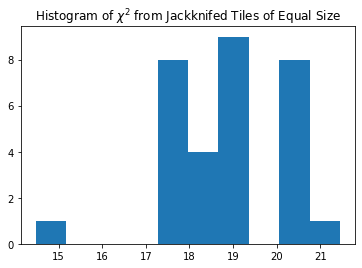

In [23]:

fig, ax = plt.subplots()
ax.hist(chi_square_array)
ax.set_title(r"Histogram of $\chi^2$ from Jackknifed Tiles of Equal Size")
plt.savefig("/home/cz136/8_30.png",dpi=300)
plt.show()
plt.close()

In [24]:
chi_sr=pd.Series(chi_square_array)

In [25]:
chi_sr.describe()

count    31.000000
mean     18.892414
std       1.308986
min      14.477646
25%      17.947434
50%      18.984704
75%      20.235824
max      21.458200
dtype: float64

In [26]:
chi_square_array

array([14.47764634, 21.45819995, 19.08427724, 20.23582443, 17.91795096,
       18.98470383, 18.17198605, 17.94743449, 19.05405553, 20.34922362,
       20.23582443, 17.91795096, 18.98470383, 18.17198605, 17.94743449,
       19.05405553, 20.34922362, 20.23582443, 17.91795096, 18.98470383,
       18.17198605, 17.94743449, 19.05405553, 20.34922362, 20.23582443,
       17.91795096, 18.98470383, 18.17198605, 17.94743449, 19.05405553,
       20.34922362])

In [27]:
keys[3]

('g', 'airmass')

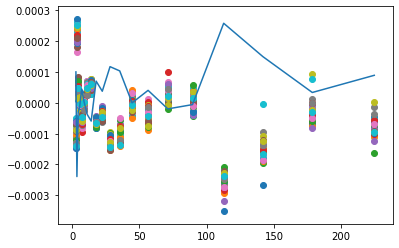

In [28]:
g_airmass_y=get_y_value(keys[3])
g_airmass_x=get_x_value(df_riz,keys[3])
g_diff_array=xi_dict[keys[3]]-xi_true_dict[keys[3]]

fig, ax = plt.subplots()
ax.plot(g_airmass_x,g_airmass_y)

for i in range(len(g_diff_array)):
    
    ax.scatter(g_airmass_x,g_diff_array[i,:])

plt.show()

In [ ]:
g_airmass_y=get_y_value(keys[3])
g_airmass_x=get_x_value(df_riz,keys[3])
g_diff_array=xi_dict[keys[3]]-xi_true_dict[keys[3]]

fig, ax = plt.subplots()
ax.plot(g_airmass_x,g_airmass_y)



plt.show()

In [ ]:
print (key)
chi_sqr=get_chi_sqr_from_df(df_riz,keys[3])
print(chi_sqr)

In [5]:
chi_sqr=np.load("/home/cz136/project/balrog/data/equalsize/chi_sqr_array.npy")

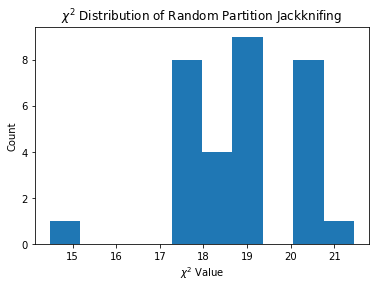

In [13]:
plt.hist(chi_sqr)
plt.xlabel("$\chi^2$ Value")
plt.ylabel("Count")
plt.title("$\chi^2$ Distribution of Random Partition Jackknifing")
plt.savefig("/home/cz136/project/balrog/data/equalsize/chi_sqr_hist")

In [11]:
pd.Series(chi_sqr).describe()

count    31.000000
mean     18.892414
std       1.308986
min      14.477646
25%      17.947434
50%      18.984704
75%      20.235824
max      21.458200
dtype: float64